Mounted at /content/gdrive
Dataset loaded
175 224 (224, 224, 3) 75 175 75


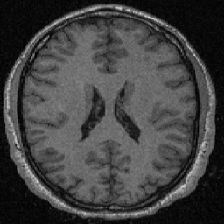

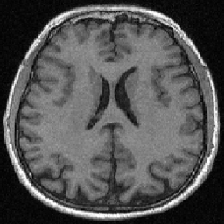

In [3]:
import numpy as np
import cv2
import os
import re
import tensorflow
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Load dataset and preprocess
healthy_path_train = '/content/gdrive/My Drive/Colab Notebooks/dataset/train/healthy'
schizophrenia_path_train = '/content/gdrive/My Drive/Colab Notebooks/dataset/train/schizophrenia'
healthy_path_test = '/content/gdrive/My Drive/Colab Notebooks/dataset/test/healthy'
schizophrenia_path_test = '/content/gdrive/My Drive/Colab Notebooks/dataset/test/schizophrenia'

def load_dataset(healthy_path_train, schizophrenia_path_train, healthy_path_test, schizophrenia_path_test):
    images_train = []
    images_test = []
    labels_train = []
    labels_test = []
    for img in os.listdir(healthy_path_train):
        img_path = os.path.join(healthy_path_train, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        images_train.append(image)
        labels_train.append(0)
    for img in os.listdir(schizophrenia_path_train):
        img_path = os.path.join(schizophrenia_path_train, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        images_train.append(image)
        labels_train.append(1)
    for img in os.listdir(healthy_path_test):
        img_path = os.path.join(healthy_path_test, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        images_test.append(image)
        labels_test.append(0)
    for img in os.listdir(schizophrenia_path_test):
        img_path = os.path.join(schizophrenia_path_test, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        images_test.append(image)
        labels_test.append(1)
    return np.array(images_train), np.array(images_test), np.array(labels_train), np.array(labels_test)

X_train_dl, X_test_dl, y_train_dl, y_test_dl = load_dataset(healthy_path_train, schizophrenia_path_train, healthy_path_test, schizophrenia_path_test)
print("Dataset loaded")

#print(X_train_dl, X_test_dl, y_train_dl, y_test_dl)
print(len(X_train_dl),len(X_train_dl[0]), X_train_dl[0].shape, len(X_test_dl), len(y_train_dl), len(y_test_dl))

from google.colab.patches import cv2_imshow
cv2_imshow(X_train_dl[5])
cv2_imshow(X_test_dl[5])

In [4]:
import os
import time
import numpy as np
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


#X_train_dl_split, X_test_dl_split, y_train_dl_split, y_test_dl_split  = X_train_dl, X_test_dl, to_categorical(y_train_dl, num_classes=2), to_categorical(y_test_dl, num_classes=2)
#print(len(X_train_dl_split),len(X_train_dl_split[0]), X_train_dl_split[0].shape, len(X_test_dl_split), len(y_train_dl_split),  len(y_test_dl_split))

# Build and compile the model
base_model = tensorflow.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()
base_model.trainable = False

# Freeze all layers except the last 3 convolutional layers
for layer in base_model.layers[-36:]:
    layer.trainable = True
for layer in base_model.layers:
    print("{0}:\t{1}".format(layer.trainable, layer.name))

model = Sequential([
    layers.Rescaling(1./224),
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(2048, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(4096, activation = 'relu'),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

Epoch 1/50
5/5 [==============================] - 2s 314ms/step - loss: 0.3974 - accuracy: 0.9143 - val_loss: 4.1498 - val_accuracy: 0.2000
Epoch 2/50
5/5 [==============================] - 1s 305ms/step - loss: 0.2897 - accuracy: 0.8429 - val_loss: 0.8003 - val_accuracy: 0.7143
Epoch 3/50
5/5 [==============================] - 1s 307ms/step - loss: 0.1326 - accuracy: 0.9357 - val_loss: 2.5417 - val_accuracy: 0.4000
Epoch 4/50
5/5 [==============================] - 1s 297ms/step - loss: 0.1235 - accuracy: 0.9714 - val_loss: 1.2135 - val_accuracy: 0.6857
Epoch 5/50
5/5 [==============================] - 1s 299ms/step - loss: 0.0908 - accuracy: 0.9786 - val_loss: 1.8198 - val_accuracy: 0.6000
Epoch 6/50
5/5 [==============================] - 1s 310ms/step - loss: 0.0475 - accuracy: 0.9786 - val_loss: 2.5205 - val_accuracy: 0.5714
Epoch 7/50
5/5 [==============================] - 2s 317ms/step - loss: 0.1642 - accuracy: 0.9714 - val_loss: 3.7593 - val_accuracy: 0.3714
Epoch 8/50
5/5 [====

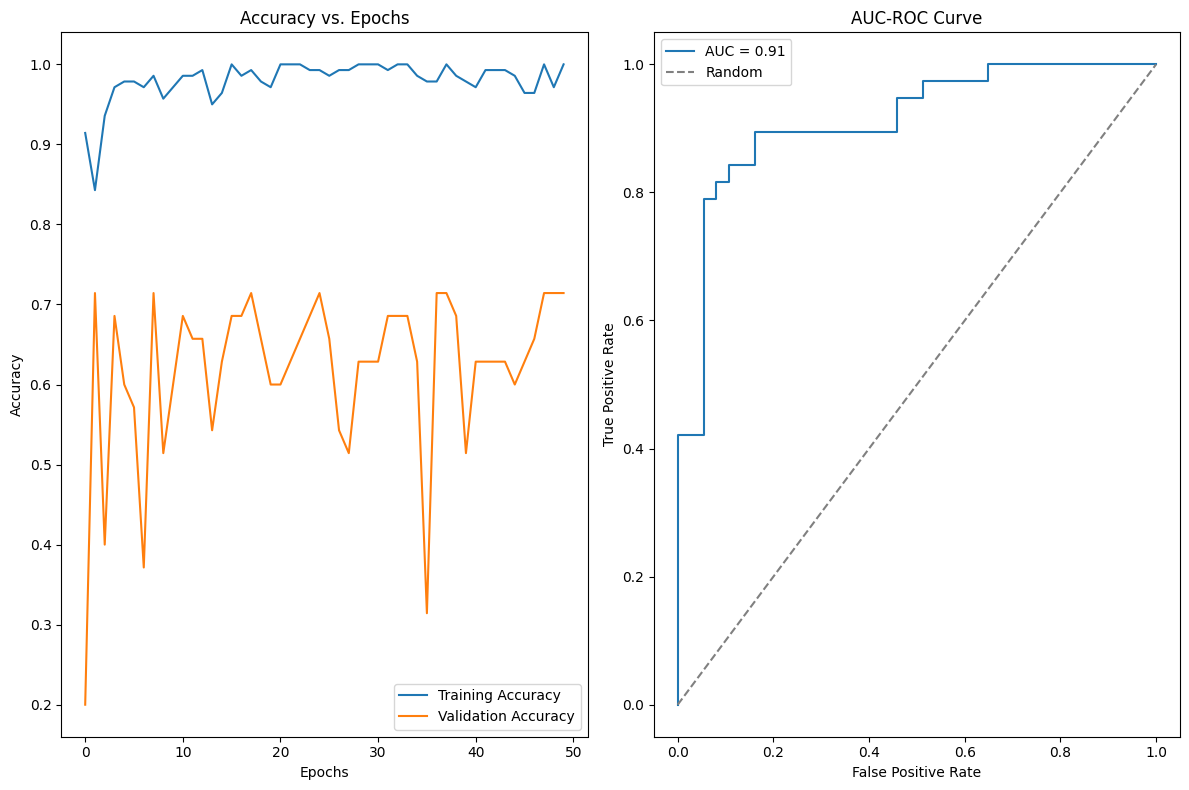

Test loss: 0.8378841280937195
Test accuracy: 0.8666666746139526
Sensitivity(recall): 0.8157894736842105
Specificity: 0.918918918918919
Precision: 0.9117647058823529
F1 Score: 0.861111111111111
AUC-ROC Score: 0.9118065433854908
[[34  3]
 [ 7 31]]
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 flatten_7 (Flatten)         (None, 100352)            0         
                                                                 
 dense_28 (Dense)            (None, 1024)              102761472 
                                                                 
 dropout_14 (Dropout)        (None, 1024)              0         
      

In [ ]:
history = model.fit(
    x = X_train_dl_split,#np.concatenate((X_train_dl_split, X_test_dl_split[:20])),
    y = y_train_dl_split,#np.concatenate((y_train_dl_split, y_test_dl_split[:20])),
    epochs=50,
    #validation_data = (X_test_dl_split, y_test_dl_split)
    validation_split= 0.2
)

# Evaluate the model
scores = model.evaluate(X_test_dl_split, y_test_dl_split, verbose=1)
y_pred_dl = model.predict(X_test_dl)
y_pred_classes = np.argmax(y_pred_dl, axis=1)
y_true_classes = np.argmax(y_test_dl_split, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
specificity = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
recall = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])

# Plot training history
plt.figure(figsize=(12, 8))
# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')  # Corrected ylabel to 'Accuracy'
plt.title('Accuracy vs. Epochs')
plt.legend()

# Plot AUC-ROC
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_true_classes, y_pred_dl[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Print evaluation results
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Sensitivity(recall):', recall)
print('Specificity:', specificity)
print('Precision:', precision_score(y_true_classes, y_pred_classes))
print('F1 Score:', f1_score(y_true_classes, y_pred_classes))
print('AUC-ROC Score:', roc_auc_score(y_true_classes, y_pred_dl[:, 1]))
print(conf_matrix)
model.summary()
